In [1]:
%load_ext autoreload

In [2]:
%autoreload now

In [3]:
from qlearning import QLearning_Agent
from sarsa import SARSA_Agent
from value_iteration import ValueIteration_Agent

In [4]:
import multilevelsuccessoroptions.envs.tabular as envs
import multilevelsuccessoroptions.utils.plotting as plotting
from multilevelsuccessoroptions.options.tabular.hierarchical_access_options import HAOS_Generator
from multilevelsuccessoroptions.successor_representation import SuccessorRepresentation

In [5]:
from simpleoptions import PrimitiveOption

In [6]:
import hdbscan
import numpy as np
from numpy.random import default_rng
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [7]:
seed = 12345
rng = default_rng(seed)
env = envs.FourRooms(rng, exploration=False)

In [8]:
primitives = [PrimitiveOption(a,env) for a in env.get_action_space()]
env.set_options(primitives)

gamma = 0.99
min_cluster_size = 9
min_samples = 5

sr = SuccessorRepresentation(env,gamma,0.2,True)
model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_method='eom',gen_min_span_tree=True, approx_min_span_tree=False,prediction_data=True, allow_single_cluster=False)
gtr = HAOS_Generator(sr, model, rng, exploration_steps = 500_000, training_steps = 0, cut_off = 1_000, n_step_updates = True, multiprocessing = False, termination_factor = 1.0, alpha = 0.2, gamma = 1.0)
gtr.generate_options(env)

Hierarchy complete
Collected trajectories
Options defined
Training Options
Training layer 2
Training layer 1
Trained Options


In [9]:
termination_chances = gtr.options_dict["105_106"].termination_chance
env = envs.FourRoomsStochasticTermination(rng, termination_chances, False, 0.0)

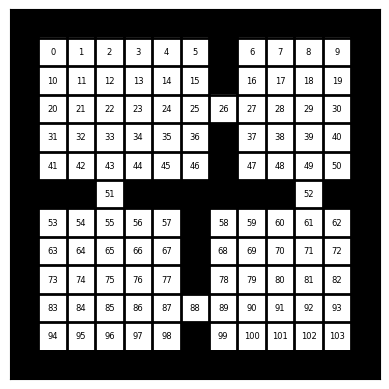

In [10]:
plotting.plot_maze_env(env);

In [11]:
actions = env.get_action_space()

In [12]:
q_agent = QLearning_Agent(rng, actions, 0.99, 0.4, 0.2, 1.0, 0.0)
q_agent.run(env, int(1e6))

In [13]:
def plot_agent_policy(agent, env):
    greedy_actions = [agent.get_greedy_actions(state) for state in range(env.num_states)]
    l = 0.4
    arrows = [(0, -l), (0, l), (-l, 0), (l, 0)]
    # Prepare the plot showing the gridworld's structure.
    gridworld_map = env.gridworld.copy()
    gridworld_map[gridworld_map != "#"] = 1.0
    gridworld_map[gridworld_map == "#"] = 0.0
    gridworld_map = gridworld_map.astype(float)

    # Plot the gridworld's structure.
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(["black", "white"])
    norm = colors.BoundaryNorm(range(cmap.N), cmap.N)
    ax.imshow(gridworld_map, cmap=cmap, norm=norm, zorder=0)

    # Prepare the heatmap plot
    res = np.copy(gridworld_map)
    alphas = np.zeros_like(res)
    ys, xs = np.nonzero(gridworld_map != 0.0)
    for coord in zip(ys, xs):
        y, x = coord
        index = env._coords_to_index(coord)

        for a in greedy_actions[index]:
            ax.arrow(
                x,
                y,
                *arrows[a],
                length_includes_head=True,
                head_width=0.2,
                head_length=0.2,
                color="k",
                zorder=2,
            )

    cmap = mpl.colormaps["Reds"]
    cmap.set_bad("blue")
    ax.imshow(res, zorder=1, alpha=alphas, cmap=cmap)

    # Set tick labels and gridlines.
    ax.grid(which="major", axis="both", linestyle="-", color="k", linewidth=2, zorder=1)
    ax.tick_params(left=False, bottom=False)
    ax.set_xticks(np.arange(-0.5, gridworld_map.shape[1], 1))
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(-0.5, gridworld_map.shape[0], 1))
    ax.set_yticklabels([])

    plt.show()

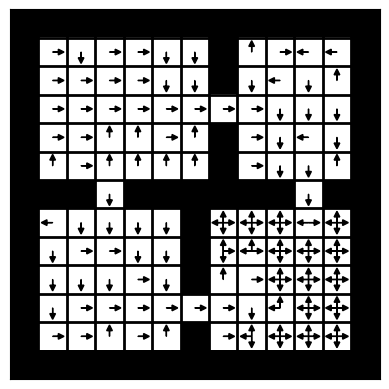

In [14]:
plot_agent_policy(q_agent,env)

In [15]:
sarsa_agent = SARSA_Agent(rng, actions, 0.99, 0.4, 0.2, 1.0, 0.0)
sarsa_agent.run(env,int(1e6))

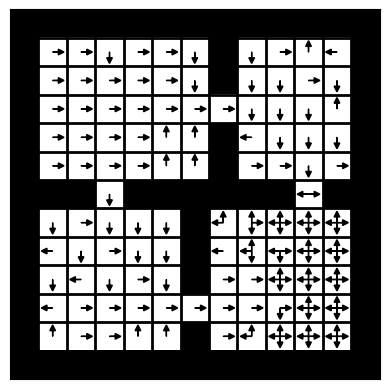

In [16]:
plot_agent_policy(sarsa_agent,env)

In [27]:
value_iteration_agent = ValueIteration_Agent(rng, actions, 0.99, 1e-15, 1.0)
value_iteration_agent.run(env,None)

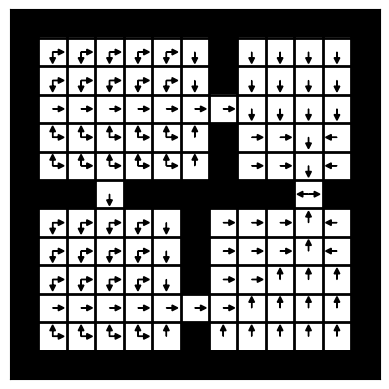

In [28]:
plot_agent_policy(value_iteration_agent,env)

In [31]:
num_layers = 2
ratio_sum = sum([(n + 1) / (num_layers + 1) for n in range(num_layers + 1)])
p = [(n + 1) / ((num_layers + 1) * ratio_sum) for n in range(num_layers + 1)]
print(p)

[0.16666666666666666, 0.3333333333333333, 0.5]
